In [1]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="colorblind6",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 5
YEAR = 365 * 24 * 60 * 60
USE_SIMULATED_TIME = False

if USE_SIMULATED_TIME:
    X_LABEL = "Simulated time, years"
else:
    X_LABEL = "Time step number"


data = {
    "Only CPR": load_data('../1/thermal_cpr', n_newest=NUM_SIMS),
    "Only Schur": load_data('../1/thermal_schur', n_newest=NUM_SIMS),
    "CPR and Schur only": load_data('../1/thermal_dynamic', n_newest=NUM_SIMS),
    "Many solvers": load_data("thermal_many_solvers", n_newest=NUM_SIMS),
    "Many solvers gp": load_data("thermal_many_solvers_gp", n_newest=NUM_SIMS),
    # "Random": load_data("thermal_random", n_newest=NUM_SIMS),
    # "Source location coldstart": load_data("thermal_coldstart_source_location", n_newest=NUM_SIMS),
    # "Source location warmstart": load_data("thermal_warmstart_source_location", n_newest=NUM_SIMS),
}

save_media_path = Path("media")
save_media_path.mkdir(exist_ok=True)

Loading data:
/home/porepy/solver_selector/examples/4_extended_solver_space/../1/performance/thermal_cpr_0.npy
/home/porepy/solver_selector/examples/4_extended_solver_space/../1/performance/thermal_cpr_1.npy
/home/porepy/solver_selector/examples/4_extended_solver_space/../1/performance/thermal_cpr_2.npy
/home/porepy/solver_selector/examples/4_extended_solver_space/../1/performance/thermal_cpr_3.npy
/home/porepy/solver_selector/examples/4_extended_solver_space/../1/performance/thermal_cpr_4.npy
Loading data:
/home/porepy/solver_selector/examples/4_extended_solver_space/../1/performance/thermal_schur_0.npy
/home/porepy/solver_selector/examples/4_extended_solver_space/../1/performance/thermal_schur_1.npy
/home/porepy/solver_selector/examples/4_extended_solver_space/../1/performance/thermal_schur_2.npy
/home/porepy/solver_selector/examples/4_extended_solver_space/../1/performance/thermal_schur_3.npy
/home/porepy/solver_selector/examples/4_extended_solver_space/../1/performance/thermal_schu

Only CPR 232.54385957717895 2.2964863777160645
Only Schur 130.70570039749146 0.8308825492858887
CPR and Schur only 110.7142566204071 1.1980724334716797
Many solvers 437.71352977752684 9.811903238296509
Many solvers gp 163.78459091186522 41.34964299201965


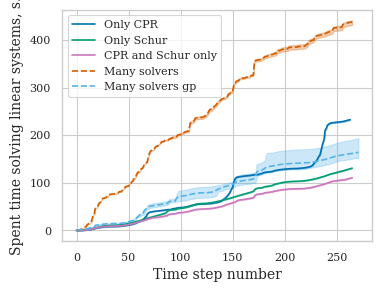

In [2]:
best_time = float("inf")
plt.figure(figsize=(4, 3))

COLORS = {
    'Only CPR': 'C0',
    'Only Schur': 'C1',
    'CPR and Schur only': 'C3',
    'Many solvers': 'C2',
    'Many solvers gp': 'C5',
}

for name, values in data.items():
    result = []
    times = []

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])
        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    if mean[-1] < best_time:
        best_time = mean[-1]
        best = mean
    plt.fill_between(x_space, min_, max_, color=COLORS[name], alpha=0.3)
    kwargs = dict()
    if name in ['Many solvers', 'Many solvers gp']:
        kwargs['linestyle'] = '--'

    plt.plot(x_space, mean, color=COLORS[name], label=name, **kwargs)
    print(name, np.mean(total), np.max(total) - np.min(total))
    if USE_SIMULATED_TIME:
        assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend(loc='upper left')
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "experiment4_performance.pdf", bbox_inches="tight")

Many solvers


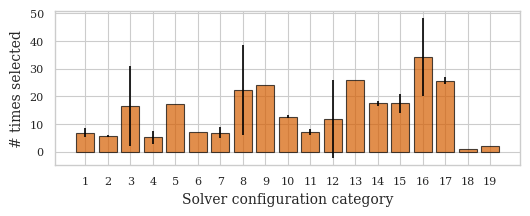

Many solvers gp


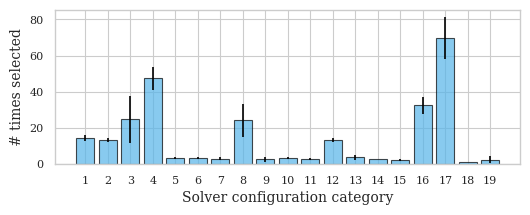

0


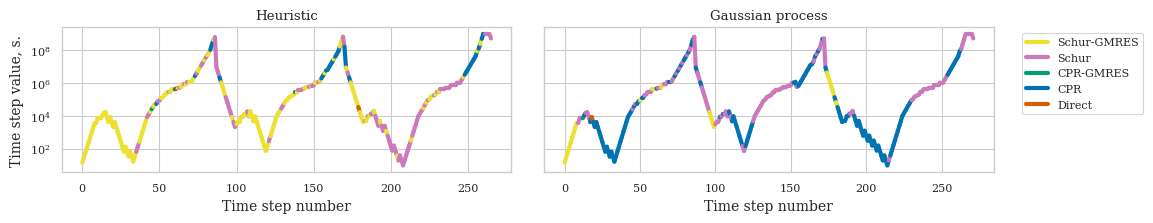

1


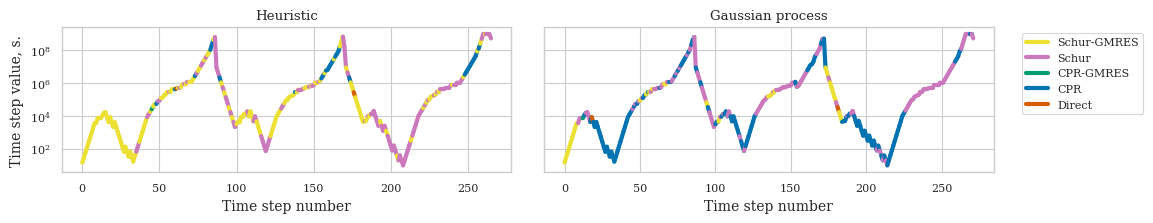

2


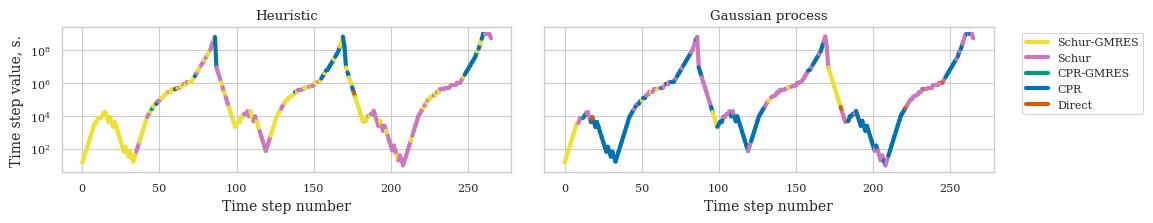

3


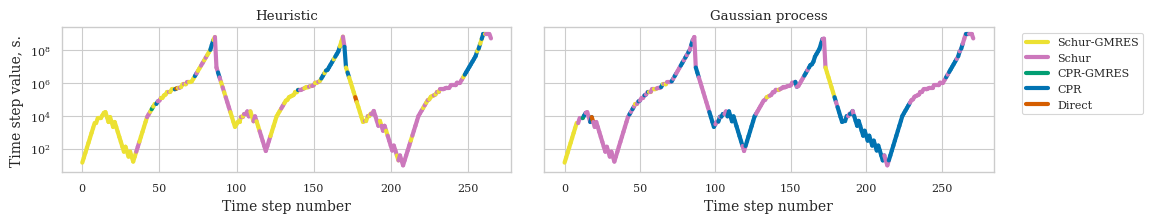

4


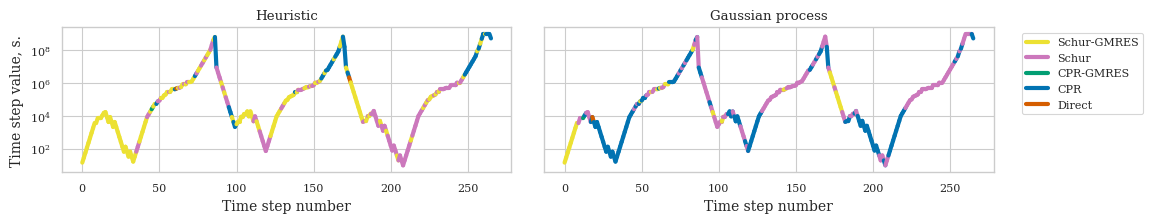

In [3]:
RIGHT_ORDER = {
    "gmres - schur_cd [primary - amg, secondary - amg, method=lower]": 0,
    "gmres - schur_cd [primary - amg, secondary - amg, method=upper]": 1,
    "gmres - schur_cd [primary - amg, secondary - amg, method=full]": 2,
    "gmres - cpr [primary - amg, secondary - ilu]": 3,
    "fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]": 4,
    "fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]": 5,
    "fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]": 6,
    "fgmres - schur_cd [primary - amg, secondary - amg, method=lower]": 7,
    "fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]": 8,
    "fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]": 9,
    "fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]": 10,
    "fgmres - schur_cd [primary - amg, secondary - amg, method=upper]": 11,
    "fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]": 12,
    "fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]": 13,
    "fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]": 14,
    "fgmres - schur_cd [primary - amg, secondary - amg, method=full]": 15,
    "fgmres - cpr [primary - amg, secondary - ilu]": 16,
    "fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]": 17,
    "direct": 18,
}


def cluster_solvers(solver_string: str):
    if solver_string == "direct":
        return "Direct"
    cpr = solver_string.find("cpr") != -1
    only_one_gmres = solver_string.rindex("gmres") == solver_string.index("gmres")
    if only_one_gmres:
        if cpr:
            return "CPR"
        else:
            return "Schur"
    else:
        if cpr:
            return "CPR-GMRES"
        else:
            return "Schur-GMRES"


def make_solver_colors(data: Sequence[SolverSelectionData], cluster: bool):
    def make_hashable(x: SolverSelectionData):
        return tuple(x.prediction.decision.subsolvers.items())

    from thermal_solvers import make_thermal_solver_space

    solver_space = make_thermal_solver_space("full")
    all_solvers = solver_space.get_all_solvers()

    subsolvers = list({make_hashable(x) for x in data})
    subsolvers_to_number = {subsolver: i for i, subsolver in enumerate(subsolvers)}

    right_order = {}

    solver_names = dict()
    for subsolvers, i in subsolvers_to_number.items():
        config = None
        tested = list(dict(subsolvers).values())
        for solver_template in all_solvers:
            expected = list(solver_template.subsolvers.values())
            if tested == expected:
                config = solver_space.config_from_decision(
                    solver_template.use_defaults(), optimized_only=True
                )
                break
        assert config is not None
        solver_name = solver_space.format_config(config)
        right_order[i] = RIGHT_ORDER[solver_name]
        solver_names[RIGHT_ORDER[solver_name]] = solver_name

    solver_names = {k: solver_names[k] for k in sorted(solver_names)}
    subsolvers_to_number = {k: right_order[v] for k, v in subsolvers_to_number.items()}

    data = [subsolvers_to_number[make_hashable(entry)] for entry in data]
    if not cluster:
        return data, solver_names

    data = [cluster_solvers(solver_names[i]) for i in data]
    cluster_names: list = np.unique(data).tolist()
    data = [cluster_names.index(x) for x in data]
    cluster_names = {i: x for i, x in enumerate(cluster_names)}
    return data, cluster_names


def color_solvers(x, values, colors, names, ax=None, legend=True):
    if ax is None:
        ax = plt.gca()

    lw = 3
    if not USE_SIMULATED_TIME:
        x = np.arange(len(values))

    names = names.copy()
    for i in range(len(x)):
        x_ = x[i : i + 2]
        val = values[i : i + 2]
        color = colors[i]
        args = {}
        if color in names:
            name = names.pop(color)
            # name = color
            args["label"] = name
        if color > 9:
            args["linestyle"] = "--"
        ax.plot(x_, val, linewidth=lw, c=f"C{color}", **args)
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


def plot_hist(solver_colors, name):
    plt.figure(figsize=(6, 2))
    bins = np.arange(np.unique(solver_colors).size + 1)
    plt.hist(solver_colors, bins=bins, color=COLORS[name])
    plt.xticks(ticks=bins[:-1] + 0.5, labels=bins[:-1] + 1)
    plt.xlabel("Solver configuration category")
    plt.ylabel("# times selected")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"histogram_{name}.pdf", bbox_inches="tight")
    plt.show()


def plot_scatter(solver_colors, name, cluster=False):
    plt.figure(figsize=(6, 2))
    plt.scatter(
        np.arange(len(solver_colors)), solver_colors, color=COLORS[name], marker="x"
    )
    unique = np.unique(solver_colors)
    bins = np.arange(1, 5) * (unique.size // 4)
    bins = np.array([0] + bins.tolist() + [unique[-1]])
    # bins = bins[[0, 4, 9, 14, 18]]
    plt.yticks(ticks=bins, labels=bins + 1)
    plt.ylabel("Category chosen")
    plt.xlabel("Time step number")
    if cluster:
        name = f"scatterplot_cluster_{name}.pdf"
    else:
        name = f"scatterplot_{name}.pdf"
    if save_media_path is not None:
        plt.savefig(save_media_path / name, bbox_inches="tight")
    plt.show()


def plot_source(
    sim_time, inlet_rate, solver_colors, solver_names, experiment_name, cluster=False
):
    plt.figure(figsize=(6, 2))
    color_solvers(sim_time, inlet_rate, solver_colors, solver_names)
    plt.ylabel("Source rate, $m^3 s^{-1}$.")
    plt.xlabel(X_LABEL)
    plt.yscale("log")
    if cluster:
        name = f"thermal_source_cluster_{experiment_name}.pdf"
    else:
        name = f"thermal_source_{experiment_name}.pdf"
    if save_media_path is not None:
        plt.savefig(
            save_media_path / name,
            bbox_inches="tight",
        )
    plt.show()


def plot_timestep(
    sim_time, time_steps, solver_colors, solver_names, experiment_name, cluster=False
):
    plt.figure(figsize=(6, 2))
    plt.ylabel("Time step value, s.")
    plt.xlabel(X_LABEL)
    color_solvers(sim_time, time_steps, solver_colors, solver_names)
    plt.yscale("log")
    if cluster:
        name = f"thermal_dt_cluster_{experiment_name}.pdf"
    else:
        name = f"thermal_dt_{experiment_name}.pdf"
    if save_media_path is not None:
        plt.savefig(save_media_path / name, bbox_inches="tight")
    plt.show()
    # for i, name in solver_names.items():
    #     print(i, name, np.sum(np.array(solver_colors) == i))


def plot_std_hist(list_of_solver_colors, name):
    plt.figure(figsize=(6, 2))
    bins = np.arange(np.unique(list_of_solver_colors[0]).size + 1)
    y_list = []
    for solver_colors in list_of_solver_colors:
        y, new_bins = np.histogram(solver_colors, bins=bins)
        y_list.append(y)
        assert np.all(new_bins == bins)

    data = np.array(y_list)
    mean = data.mean(axis=0)
    min_ = data.min(axis=0)
    max_ = data.max(axis=0)
    std = data.std(axis=0)

    bincenters = 0.5 * (bins[1:] + bins[:-1])

    plt.bar(
        bincenters,
        mean,
        yerr=std,
        color=COLORS[name],
        alpha=0.7,
        ecolor="black",
        edgecolor="black",
    )

    # plt.bar(bincenters, mean, color=COLORS[name], alpha=0.7)
    # plt.vlines(bincenters, min_, max_, color='black')

    plt.xticks(ticks=bins[:-1] + 0.5, labels=bins[:-1] + 1)
    plt.xlabel("Solver configuration category")
    plt.ylabel("# times selected")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"histogram_{name}.pdf", bbox_inches="tight")
    plt.show()


def plot_full_hist(list_of_lists_of_solver_colors, names):
    plt.figure(figsize=(12, 2))

    bins = np.arange(np.unique(list_of_lists_of_solver_colors[0][0]).size + 1)

    num_groups = len(list_of_lists_of_solver_colors)
    offset = 0.1
    delta_offset = 0.8 / num_groups

    for list_of_solver_colors, name in zip(list_of_lists_of_solver_colors, names):
        y_list = []
        for solver_colors in list_of_solver_colors:
            y, new_bins = np.histogram(solver_colors, bins=bins)
            y_list.append(y)
            assert np.all(new_bins == bins)

        data = np.array(y_list)
        mean = data.mean(axis=0)
        min_ = data.min(axis=0)
        max_ = data.max(axis=0)
        std = data.std(axis=0)

        bincenters = 0.5 * (bins[1:] + bins[:-1])

        label = {"Many solvers": "Heuristic", "Many solvers gp": "GP"}[name]

        plt.bar(
            bins[:-1] + offset,
            mean,
            yerr=std,
            color=COLORS[name],
            alpha=0.7,
            ecolor="black",
            edgecolor="black",
            width=delta_offset,
            align="edge",
            label=label,
        )
        offset += delta_offset

    # plt.bar(bincenters, mean, color=COLORS[name], alpha=0.7)
    # plt.vlines(bincenters, min_, max_, color='black')

    plt.xticks(ticks=bins[:-1] + 0.5, labels=bins[:-1] + 1)
    plt.legend()
    plt.xlabel("Solver configuration category")
    plt.ylabel("# times selected")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"histogram_full.pdf", bbox_inches="tight")
    plt.show()


def plot_compare_heuristic_gp(
    sim_time_list, time_step_list, сolor_list_clustered, cluster_names_list, names, experiment_id
):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(10, 2), squeeze=True, sharey="row"
    )
    fig.tight_layout()
    axes[0].set_ylabel("Time step value, s.")
    for i, ax in enumerate(axes):
        ax.set_yscale("log")
        ax.set_xlabel(X_LABEL)
        color_solvers(
            sim_time_list[i],
            time_step_list[i],
            сolor_list_clustered[i],
            cluster_names_list[i],
            ax=ax,
            legend=False,
        )
        ax.set_title(
            {"Many solvers": "Heuristic", "Many solvers gp": "Gaussian process"}[
                names[i]
            ]
        )

    # if save_media_path is not None:
    #     plt.savefig(save_media_path / name, bbox_inches="tight")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    if save_media_path is not None:
        plt.savefig(
            save_media_path / f"experiment4_time_steps_{experiment_id}.pdf", bbox_inches="tight"
        )
    plt.show()


list_of_sim_times = []
list_of_time_steps = []
list_of_color_lists = []
list_of_color_lists_clustered = []
list_of_cluster_names = []
names = []

for name, vals in data.items():
    if name not in ["Many solvers", "Many solvers gp"]:
        continue
    colors_list = []
    solver_names_list = []
    time_step_list = []
    inlet_rate_list = []
    sim_time_list = []
    сolor_list_clustered = []
    cluster_names_list = []
    for perf in vals:
        solver_colors, solver_names = make_solver_colors(perf, cluster=False)
        colors_list.append(solver_colors)
        solver_names_list.append(solver_names)
        solver_colors, solver_names = make_solver_colors(perf, cluster=True)
        сolor_list_clustered.append(solver_colors)
        cluster_names_list.append(solver_names)

        time_step_list.append(make_time_step(perf, converged=CONVERGED))
        inlet_rate_list.append(make_inlet_rate(perf, converged=CONVERGED))
        sim_time_list.append(make_simulation_time(perf, converged=CONVERGED))

    list_of_color_lists.append(colors_list)
    list_of_sim_times.append(sim_time_list)
    list_of_time_steps.append(time_step_list)
    list_of_color_lists_clustered.append(сolor_list_clustered)
    list_of_cluster_names.append(cluster_names_list)
    names.append(name)

    print(name)
    plot_std_hist(colors_list, name)

    # print(name)
    # for i in range(len(vals)):
    #     print(name, i)
    #     plot_scatter(colors_list[i], name)
    #     plot_scatter(сolor_list_clustered[i], name, cluster=True)
    #     plot_hist(colors_list[i], name)
    #     plot_source(sim_time_list[i], inlet_rate_list[i], colors_list[i], solver_names_list[i], name)
    #     plot_timestep(sim_time_list[i], time_step_list[i], colors_list[i], solver_names_list[i], name)
    #     plot_source(sim_time_list[i], inlet_rate_list[i], сolor_list_clustered[i], cluster_names_list[i], name, cluster=True)
    #     plot_timestep(sim_time_list[i], time_step_list[i], сolor_list_clustered[i], cluster_names_list[i], name, cluster=True)

# plot_full_hist(list_of_color_lists, names)

for i in range(NUM_SIMS):
    print(i)
    plot_compare_heuristic_gp(
        [list_of_sim_times[0][i], list_of_sim_times[1][i]],
        [list_of_time_steps[0][i], list_of_time_steps[1][i]],
        [list_of_color_lists_clustered[0][i], list_of_color_lists_clustered[1][i]],
        [list_of_cluster_names[0][i], list_of_cluster_names[1][i]],
        names,
        i,
    )

In [4]:
for i, name in solver_names_list[0].items():
    print(i+1 ,name)

1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
2 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
3 gmres - schur_cd [primary - amg, secondary - amg, method=full]
4 gmres - cpr [primary - amg, secondary - ilu]
5 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
6 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
7 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
8 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
9 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
10 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
11 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
12 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
13 fgmres - schur_cd [primary - gmres [amg, restart=10], 

In [5]:
gb_data = np.load('/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_10.npy', allow_pickle=True).tolist()
gp_data = np.load('/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_9.npy', allow_pickle=True).tolist()

gp_metrics = np.load('/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_9_metrics.npy', allow_pickle=True).item()
gb_metrics = np.load('/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_10_metrics.npy', allow_pickle=True).item()

def plot_overhead(data, metrics, name, label):

    colors, _ = make_solver_colors(data, cluster=False)
    colors = np.array(colors)

    values, count = np.unique(colors, return_counts=True)
    argsort = np.argsort(count)[::-1]
    count = count[argsort]
    values = values[argsort]
    most_common_solver = colors == values[0]

    timesteps_where_used = np.where(most_common_solver)[0]

    update = np.array(metrics['update_selector_times'])[most_common_solver]
    select = np.array(metrics['select_solver_times'])[most_common_solver]

    plt.scatter(timesteps_where_used, update, label=label + ' update', color=COLORS[name])


plt.figure(figsize=(4, 3))
plot_overhead(gb_data, gb_metrics, 'Many solvers', 'Heuristic')
plot_overhead(gp_data, gp_metrics, 'Many solvers gp', 'GP')
plt.yscale('log')
plt.ylabel('Non-cumulative overhead, s')
plt.xlabel('Time step number')
plt.legend()

if save_media_path is not None:
    plt.savefig(save_media_path / "overheads.pdf", bbox_inches="tight")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_10.npy'